# Evaluating Segmentation Results

This notebook compares the results of image segmentation by different techniques with the ground truths.

The ground truth comes from 4 hand-labeled images taken over Northeast Greenland in Spring of 2017. The techniques (models) that I will compare are:

* **SAM64**: SAM automatic mask generator using 64 points per side.
* **SAM256**: SAM automatic mask generator using 256 points per side.
* **IceFloeTracker**: A morphology-based algorithm used in an 2019 paper.
* **GD+SAM**: GroundingDINO for object detection and SAM.

The metrics that I will use are:

* Number of ice floes
* IoU
* Dice Coefficient (F1 score), which is equivalent to IoU in this case

In [1]:
from pathlib import Path

import cv2
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageChops, ImageOps
import torch
import torchvision
from skimage.morphology import erosion, dilation, square
from skimage.measure import label, regionprops

from segment_anything import SamAutomaticMaskGenerator
from groundingdino.util.inference import load_image

from gd_sam import sam_model, gd_sam_predict
from paths import *
from plotting import show_mask, add_image_and_mask

/users/yxu150/anaconda/cs2952n_new/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402374358/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 1. Pre-process ground truths

Because the ground truth images come with a large white border and red dots for centroids, we will remove the borders, resize the resulting image, and apply a threshold.

In [2]:
def process_ground_truth(img):

    img = ImageOps.grayscale(img)
    border = Image.new(img.mode, img.size, 255)
    diff = ImageChops.difference(img, border)
    bbox = diff.getbbox()
    img = img.crop(bbox).resize((1001, 1701))
    
    img_arr = np.array(img)
    img_arr[img_arr > 60] = 255
    img_arr[img_arr <= 60] = 0
    
    return img_arr // 255

In [3]:
# ground_truths = {}

# for gt_path in sorted(list(gt_dir.glob("*.tif"))):
#     img = Image.open(gt_path)
#     mask = process_ground_truth(img)

#     ground_truths[gt_path.name] = mask

# ground_truths

### 2. (Only needs to be done once) Remove land masks in ground truths

In [4]:
# Write images for landmask removal in Photoshop:
# No need to do this again

# for gt_name, gt in ground_truths.items():
    
#     Image.fromarray(gt).save(gt_dir / (gt_name + "f"))

In [5]:
ground_truths = []

for gt_name in sorted(list(gt_dir.glob("E*.tiff"))):
    mask = np.array(Image.open(gt_name))
    mask[mask == 255] = 1
    
    ground_truths.append(mask)
    
len(ground_truths)

4

### 3. Process old IceFloeTracker results

The old IceFloeTracker results not only have red dots indicating centroids, they also have a black border around the red dots. Will apply an additional step of dilation and erosion to remove the black borders. This step might introduce slight inaccuarcy for old IceFloeTracker results

In [6]:
# ift_dir = data_dir / "ift_old"

# old_ift = []

# for ift_name in sorted(list(ift_dir.glob("NE*.tif"))):
#     img = Image.open(ift_name)
#     mask = process_ground_truth(img)

#     old_ift.append(mask)
    
# len(old_ift)

In [7]:
# ift_masks = [
#     erosion(dilation(mask, square(3)), square(3))
#     for mask in old_ift
# ]

# for i, mask in enumerate(ift_masks):
#     Image.fromarray(mask).save(ift_dir / f"mask{i}.tiff")

In [8]:
ift_masks = []

for ift_path in sorted(list(ift_dir.glob("mask*.tiff"))):
    img_arr = np.array(Image.open(ift_path))
    img_arr[img_arr == 255] = 1
    ift_masks.append(img_arr)
    
len(ift_masks)

4

### 4. Get masks for all

In [9]:
sam64 = SamAutomaticMaskGenerator(
    sam_model,
    points_per_side=64,
    points_per_batch=512,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.98,
    stability_score_offset=1.0,
    box_nms_thresh=0.8,
    crop_n_layers=0,
    crop_nms_thresh=0.7,
    crop_overlap_ratio=512 / 1500,
    crop_n_points_downscale_factor=1,
    point_grids=None,
    min_mask_region_area=0,
    output_mode="binary_mask",
)

sam256 = SamAutomaticMaskGenerator(
    sam_model,
    points_per_side=256,
    points_per_batch=512,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.98,
    stability_score_offset=1.0,
    box_nms_thresh=0.8,
    crop_n_layers=0,
    crop_nms_thresh=0.7,
    crop_overlap_ratio=512 / 1500,
    crop_n_points_downscale_factor=1,
    point_grids=None,
    min_mask_region_area=0,
    output_mode="binary_mask",
)

/users/yxu150/anaconda/cs2952n_new/lib/python3.9/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/users/yxu150/anaconda/cs2952n_new/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
2023-05-08 16:17:45.503928: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


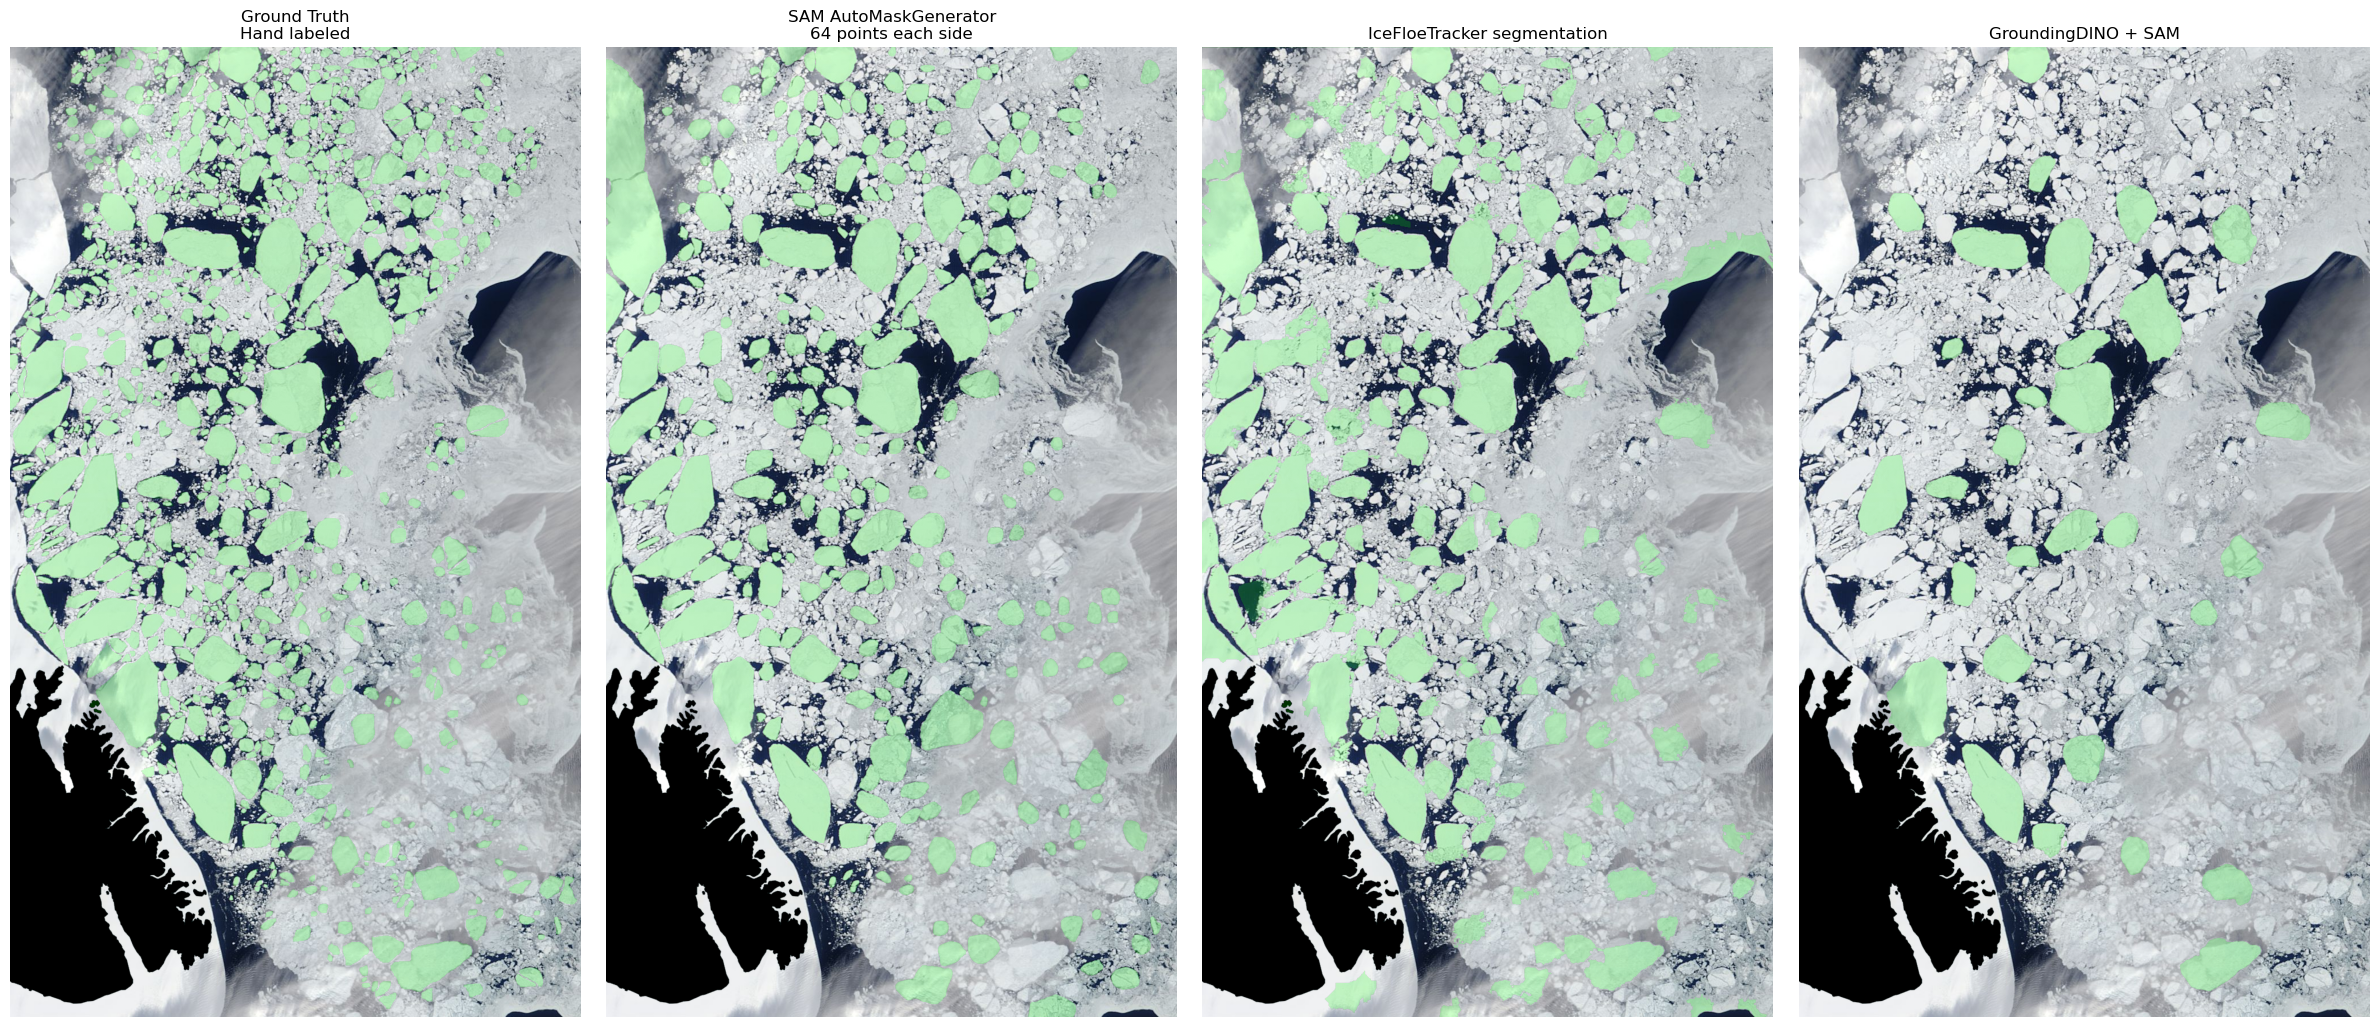

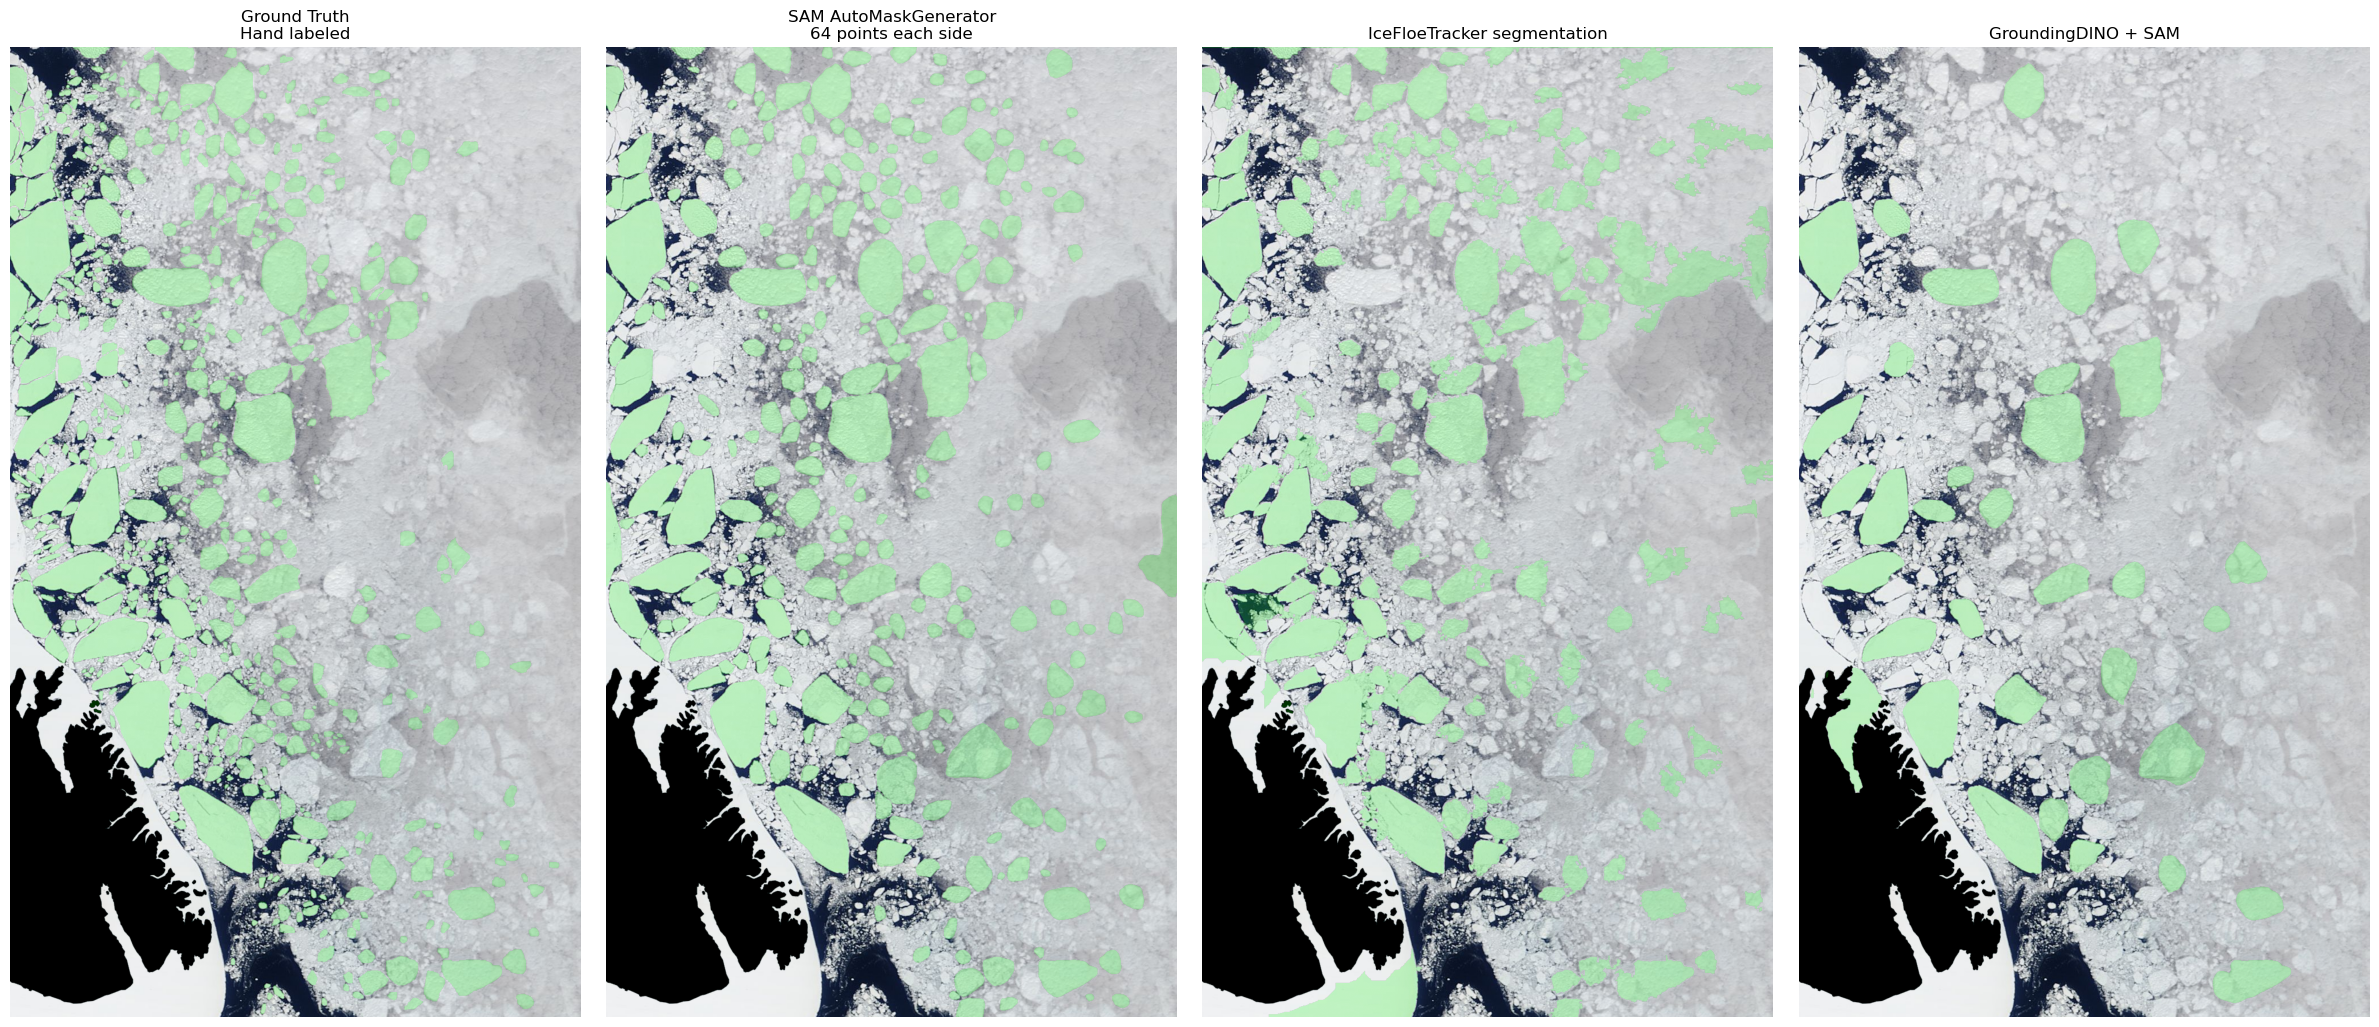

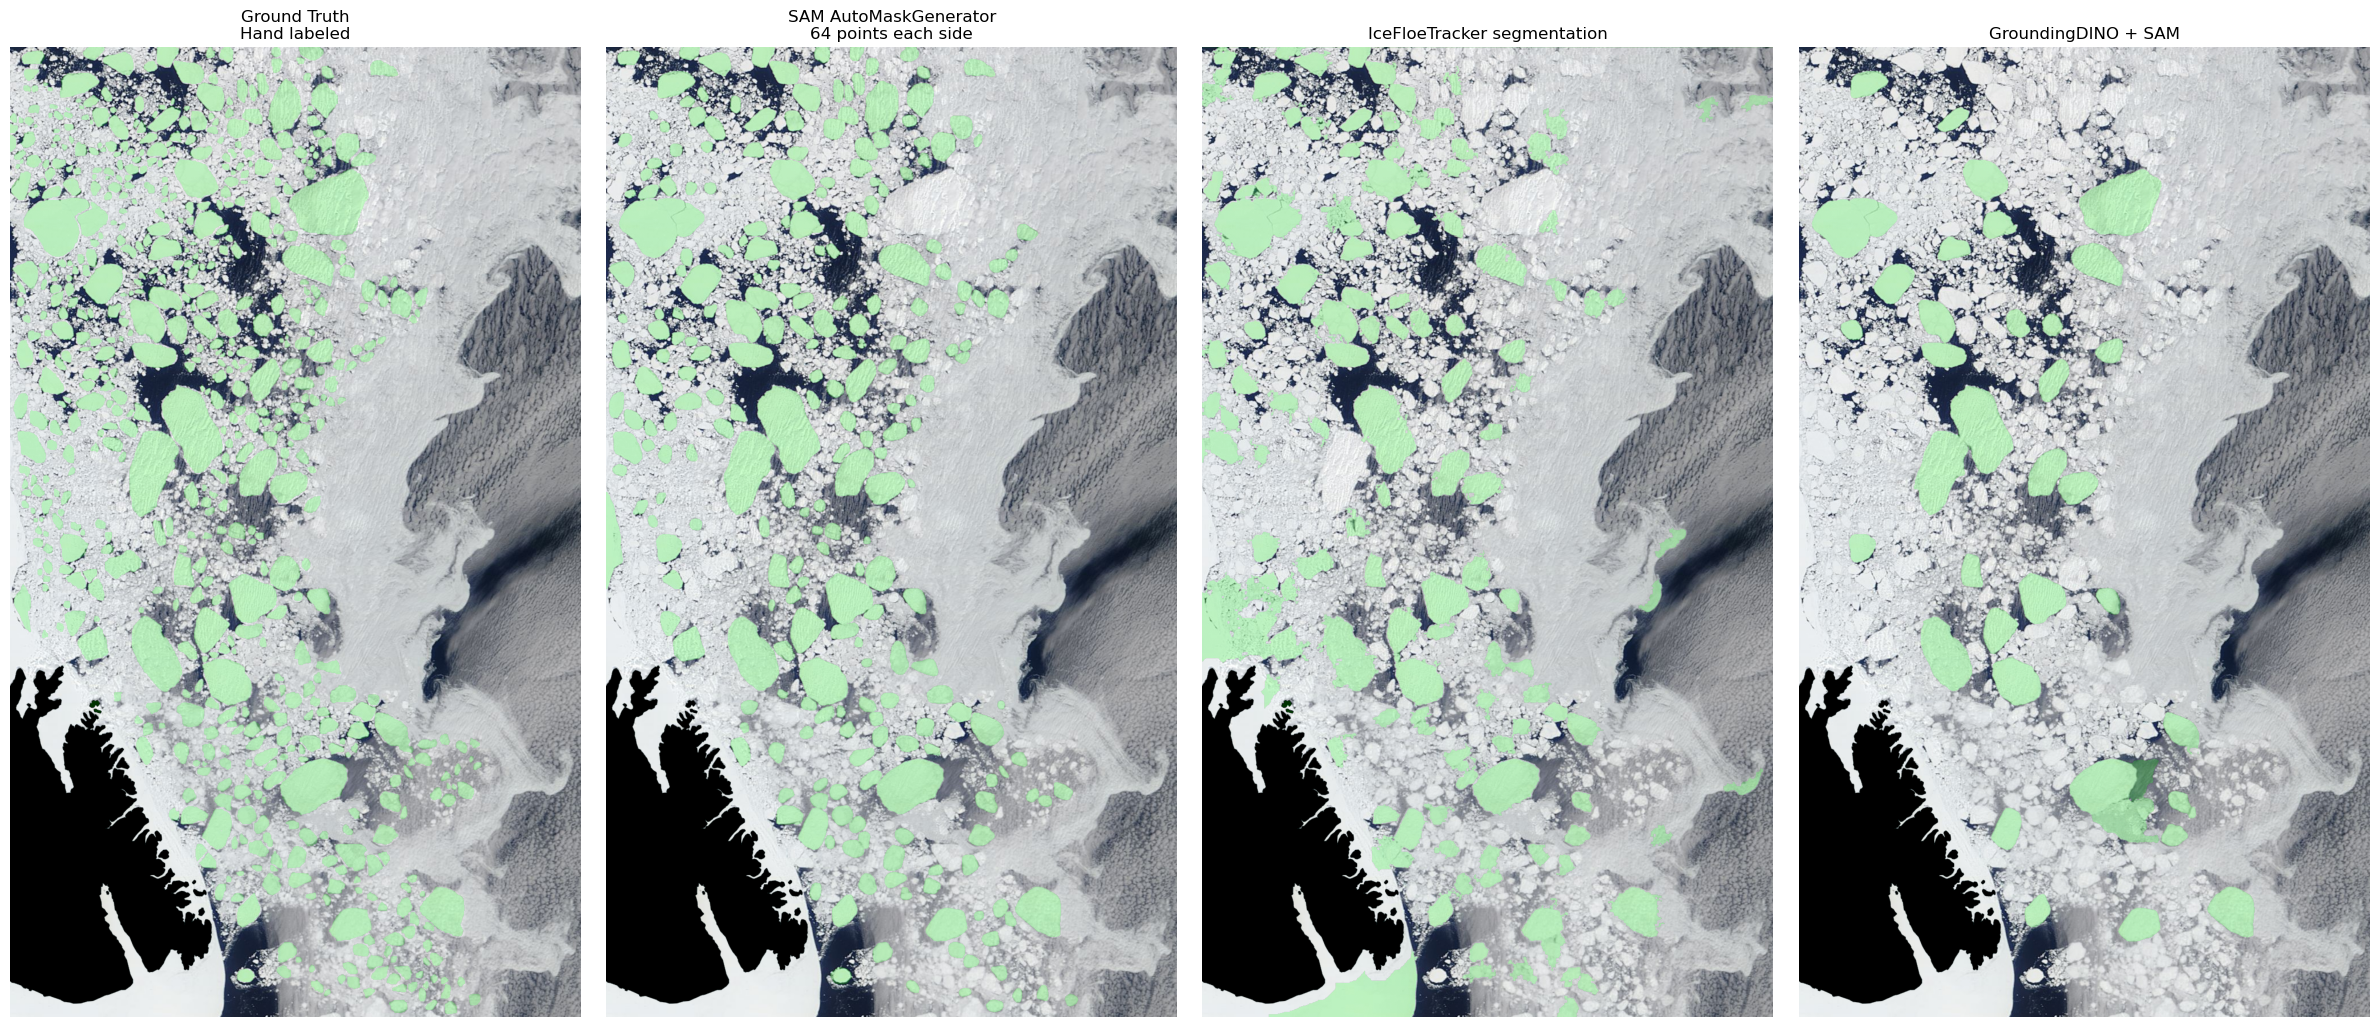

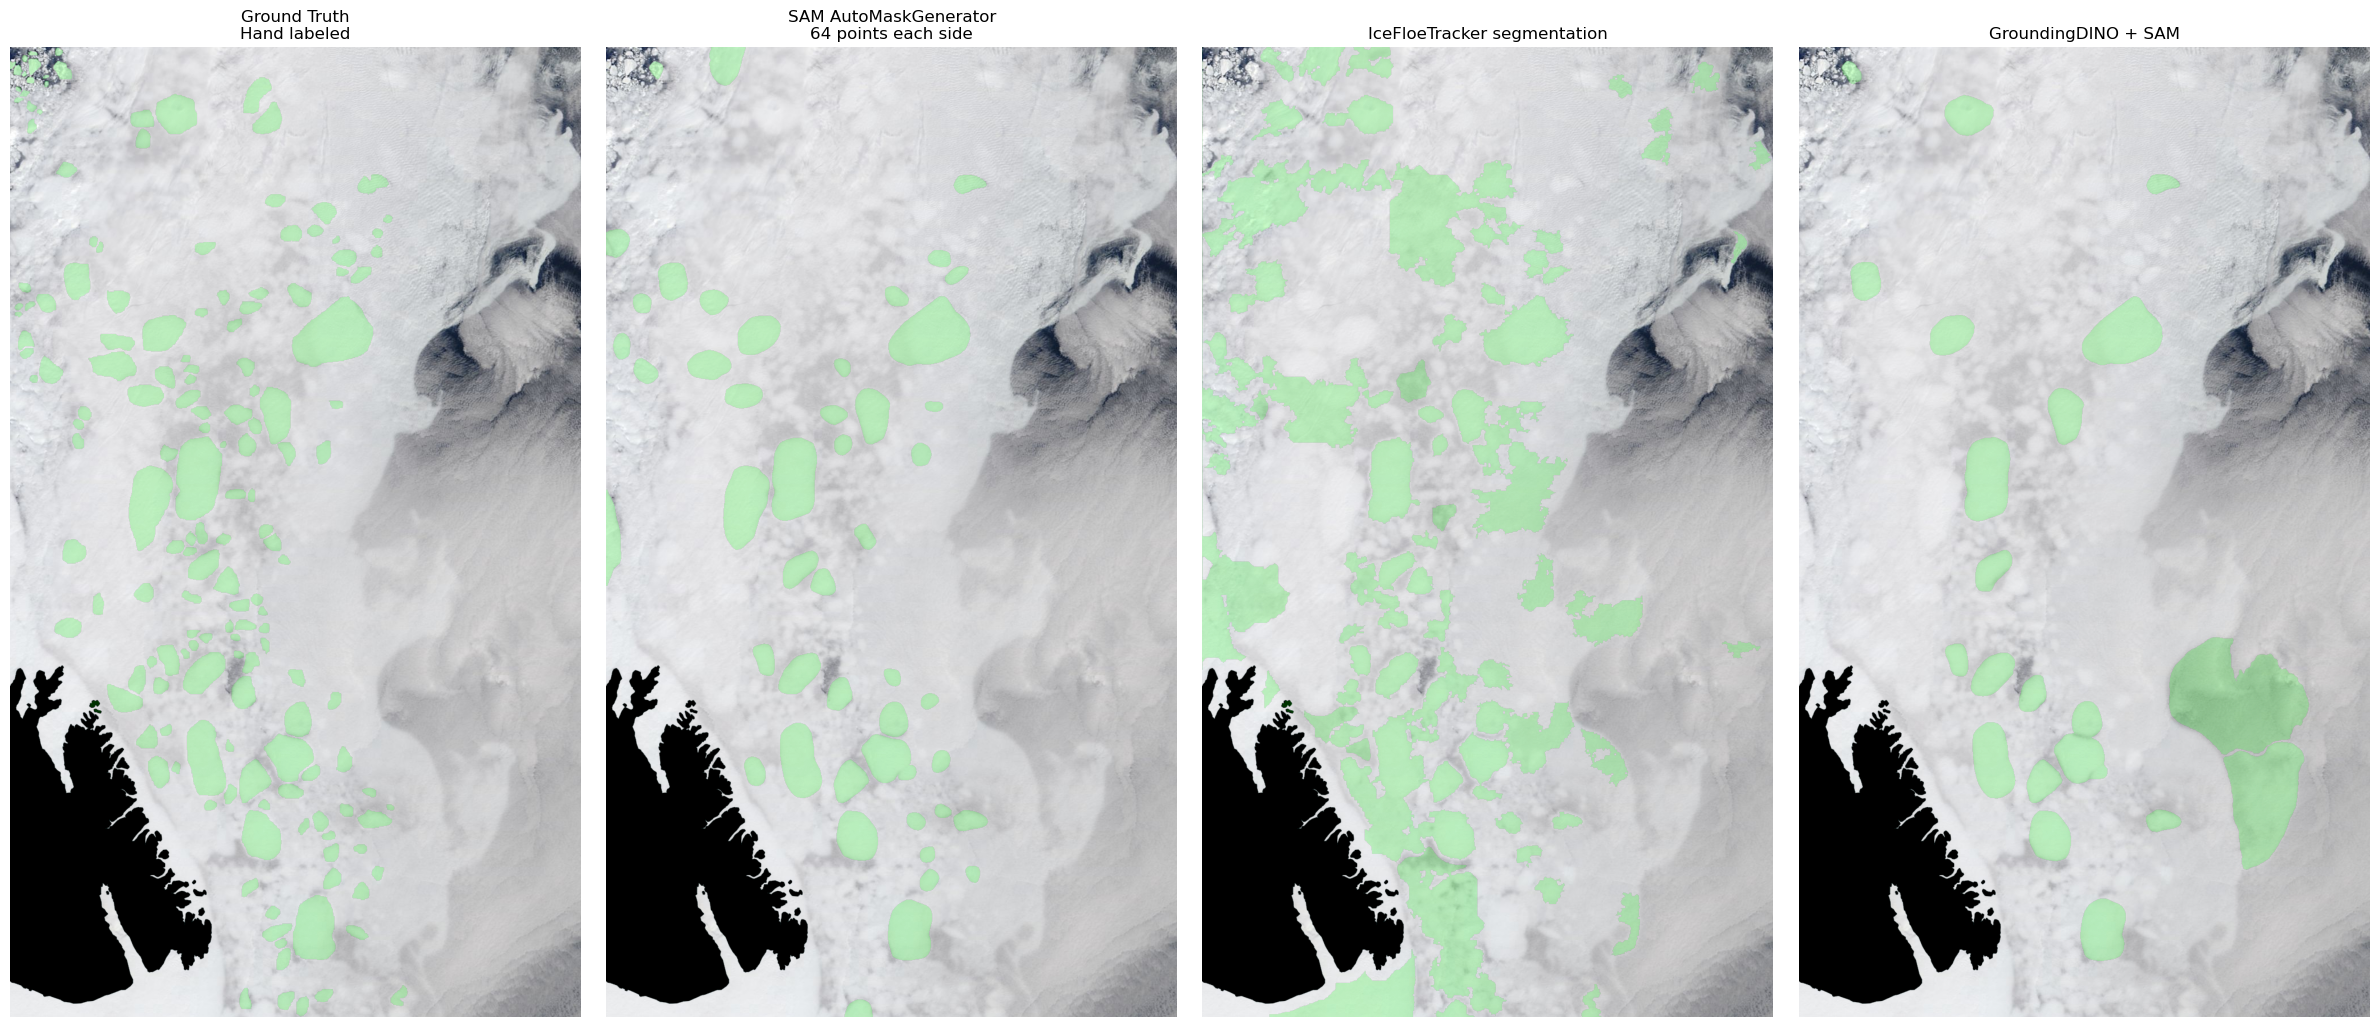

In [10]:
results = []

for i, image_name in enumerate(sorted(test_dir.glob("*.tif"))):
    
    result = {}
    
    sam_image, gd_image = load_image(image_name)
    result["image"] = sam_image
    
    sam64_masks = sam64.generate(sam_image)
    sam64_masks = [
        d["segmentation"] 
        for d in sam64_masks
        if d["area"] < 90000 
        and sam_image[d["segmentation"]].mean() > 255 * 0.7
    ]  
    sam64_mask = np.stack(sam64_masks).any(axis=0)
    
    result["sam64_mask"] = sam64_mask
    result["sam64_masks"] = sam64_masks
    result["sam64_nmasks"] = len(sam64_masks)
    
    sam256_masks = sam256.generate(sam_image)
    sam256_masks = [
        d["segmentation"] 
        for d in sam256_masks 
        if d["area"] < 90000 
        and sam_image[d["segmentation"]].mean() > 255 * 0.7
    ]
    sam256_mask = np.stack(sam256_masks).any(axis=0)
    
    result["sam256_mask"] = sam256_mask
    result["sam256_masks"] = sam256_masks
    result["sam256_nmasks"] = len(sam256_masks)
    
    gd_sam_masks = gd_sam_predict(
        gd_image,
        sam_image,
        score_threshold=0.85,
        box_threshold=0.07,
        brightness_threshold=0.7
    )
    
    gd_sam_mask = gd_sam_masks.any(axis=0).cpu()
    result["gd_sam_mask"] = gd_sam_mask
    result["gd_sam_masks"] = gd_sam_masks
    result["gd_sam_nmasks"] = gd_sam_masks.shape[0]
    
    results.append(result)

    fig, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(1, 4, figsize=(24, 10))
    ax1.set_title("Ground Truth\nHand labeled")
    add_image_and_mask(sam_image, ground_truths[i], ax1)
    ax2.set_title("SAM AutoMaskGenerator\n64 points each side")
    add_image_and_mask(sam_image, sam64_mask, ax2)
    ax3.set_title("IceFloeTracker segmentation")
    add_image_and_mask(sam_image, ift_masks[i], ax3)
    ax4.set_title("GroundingDINO + SAM")
    add_image_and_mask(sam_image, gd_sam_mask, ax4)
    plt.tight_layout()
    fig.show()

In [11]:
colormap = {
    1: [0., 1., 0., 0.2],
    0: [0., 0., 1., 0.2]
}

In [12]:
import matplotlib.patches as mpatch
from plotting import show_mask

def add_image_and_masks(
    img,
    ax,
    mask1,
    mask2,
    colormap,
    label1="Ground truth",
    label2="Model"
):
    ax.imshow(img)
    show_mask(mask1, ax, color=colormap[0])
    show_mask(mask2, ax, color=colormap[1])
    
    patches = [
        mpatch.Patch(color=colormap[i], label=label) 
        for i, label in enumerate([label1, label2])
    ]
    
    ax.legend(handles=patches)

In [13]:
# result = results[0]
# plt.figure(figsize=(16, 16))
# add_image_and_masks(
#     result["image"],
#     plt.gca(),
#     ground_truths[0],
#     result["sam_mask"],
#     colormap,
#     label2="SAM AutoMaskGenerator"
# )
# plt.show()

### 5. Dynamically inspect effects of different parameters

In [14]:
style = {'description_width': 'initial'}

image_picker = widgets.Dropdown(
    options=[(f"image {i}", i) for i in range(4)],
    value=0,
    description='Choose an image:',
)

points_per_side = widgets.IntSlider(
    value=64,
    min=32,
    max=256,
    step=16,
    description='points_per_side: ',
    disabled=False,
    style=style,
    continuous_update=False
)

stability_score_thresh = widgets.FloatSlider(
    value=0.98,
    min=0.85,
    max=0.99,
    step=0.01,
    description='stability_score_thresh: ',
    disabled=False,
    style=style,
    continuous_update=False
)

In [15]:
def sam_automatic_predict(image_no, points_per_side, stability_score_thresh):
    
    images = sorted(list(test_dir.glob("*.tif")))
    sam_image, _ = load_image(images[image_no])
    
    sam_mask_generator = SamAutomaticMaskGenerator(
        sam_model,
        points_per_side=points_per_side,
        points_per_batch=512,
        pred_iou_thresh=0.88,
        stability_score_thresh=stability_score_thresh,
        stability_score_offset=1.0,
        box_nms_thresh=0.8,
        crop_n_layers=0,
        crop_nms_thresh=0.7,
        crop_overlap_ratio=512 / 1500,
        crop_n_points_downscale_factor=1,
        point_grids=None,
        min_mask_region_area=0,
        output_mode="binary_mask",
    )
    
    sam_masks = sam_mask_generator.generate(sam_image)
    
    sam_masks = [
        d["segmentation"] 
        for d in sam_masks 
        if d["area"] < 90000 
        and sam_image[d["segmentation"]].mean() > 255 * 0.7
    ]
        
    sam_mask = np.stack(sam_masks).any(axis=0)
    
    plt.figure(figsize=(16, 16))
    add_image_and_masks(
        sam_image,
        plt.gca(),
        ground_truths[image_no],
        sam_mask,
        colormap,
        label2="SAM AutoMaskGenerator"
    )
    plt.axis("off")
    plt.show()

In [16]:
widgets.interactive(
    sam_automatic_predict,
    image_no=image_picker,
    points_per_side=points_per_side,
    stability_score_thresh=stability_score_thresh
)

interactive(children=(Dropdown(description='Choose an image:', options=(('image 0', 0), ('image 1', 1), ('imag…

### 6. Compute IoU for all masks

In [17]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    return intersection / union

In [18]:
n_masks = []

for i, result in enumerate(results):
    gt_mask = ground_truths[i]
    ift_mask = ift_masks[i]
    
    gt_nmasks = np.max(label(gt_mask)) + 1
    ift_nmasks = np.max(label(ift_mask)) + 1
    
    n_masks.append([
        gt_nmasks,
        result["sam64_nmasks"],
        result["sam256_nmasks"],
        ift_nmasks,
        result["gd_sam_nmasks"]
    ])
    
n_masks = np.array(n_masks)

In [19]:
n_masks_df = pd.DataFrame(
    n_masks, columns=["Ground Truth", "SAM64", "SAM256", "IFT", "GroundingDINO + SAM"],
    index=(f"Image {i}" for i in range(1, 5))
)

n_masks_df

Ground Truth  SAM64  SAM256  IFT  GroundingDINO + SAM
Image 1           658    275     442  107                   56
Image 2           457    269     412   95                   72
Image 3           600    256     407   87                   73
Image 4           163     49      53   52                   35

In [20]:
iou = []

for i, result in enumerate(results):
    gt_mask = ground_truths[i]
    sam64_mask = result["sam64_mask"]
    sam256_mask = result["sam256_mask"]
    gd_mask = result["gd_sam_mask"].numpy()
    ift_mask = ift_masks[i]
    
    iou_sam64 = compute_iou(gt_mask, sam64_mask)
    iou_sam256 = compute_iou(gt_mask, sam256_mask)
    iou_gd = compute_iou(gt_mask, gd_mask)
    iou_ift = compute_iou(gt_mask, ift_mask)
    
    iou.append([iou_sam64, iou_sam256, iou_ift, iou_gd])

iou = np.array(iou)
iou

array([[0.512337  , 0.56529955, 0.45914108, 0.29368743],
       [0.59408257, 0.61770443, 0.46541986, 0.36679364],
       [0.62157042, 0.70903273, 0.43230391, 0.351743  ],
       [0.54490532, 0.55226269, 0.23381083, 0.32454798]])

In [21]:
iou_df = pd.DataFrame(
    iou, columns=["SAM64", "SAM256", "IFT", "GroundingDINO + SAM"],
    index=(f"Image {i}" for i in range(1, 5)))

iou_df

SAM64    SAM256       IFT  GroundingDINO + SAM
Image 1  0.512337  0.565300  0.459141             0.293687
Image 2  0.594083  0.617704  0.465420             0.366794
Image 3  0.621570  0.709033  0.432304             0.351743
Image 4  0.544905  0.552263  0.233811             0.324548

### 7. Evaluation after filtering by area

In [22]:
def filter_by_area(mask, amin=300, amax=90000):
    new_mask = np.zeros_like(mask)
    
    props = regionprops(label(mask))
    
    for prop in props:
        if amin <= prop.num_pixels < amax:
            min_row, min_col, max_row, max_col = prop.bbox
            new_mask[min_row:max_row, min_col:max_col] = prop.image
        
    return new_mask > 0

In [23]:
n_masks_300 = []

for i, result in enumerate(results):
    gt_mask = filter_by_area(ground_truths[i])
    ift_mask = filter_by_area(ift_masks[i])
    
    gt_nmasks = np.max(label(gt_mask)) + 1
    ift_nmasks = np.max(label(ift_mask)) + 1
    
    sam64_nmasks = len([
        mask for mask in result["sam64_masks"] if mask.sum() >= 300
    ])
    
    sam256_nmasks = len([
        mask for mask in result["sam256_masks"] if mask.sum() >= 300
    ])
    
    gd_sam_nmasks = torch.sum(result["gd_sam_masks"].sum(axis=(-2, -1)) >= 300).cpu().numpy()
    
    n_masks_300.append([
        gt_nmasks,
        sam64_nmasks,
        sam256_nmasks,
        ift_nmasks,
        gd_sam_nmasks
    ])
    
n_masks_300 = np.array(n_masks_300)

In [24]:
n_masks_300_df = pd.DataFrame(
    n_masks_300, columns=["Ground Truth", "SAM64", "SAM256", "IFT", "GroundingDINO + SAM"],
    index=(f"Image {i}" for i in range(1, 5))
)

n_masks_300_df

Ground Truth  SAM64  SAM256  IFT  GroundingDINO + SAM
Image 1           307    251     363  108                   56
Image 2           223    234     331   95                   72
Image 3           270    233     324   85                   73
Image 4           116     49      52   50                   35

In [25]:
iou_300 = []

for i, result in enumerate(results):
    gt_mask = filter_by_area(ground_truths[i])
    sam64_mask = filter_by_area(result["sam64_mask"])
    sam256_mask = filter_by_area(result["sam256_mask"])
    gd_mask = filter_by_area(result["gd_sam_mask"].numpy())
    ift_mask = filter_by_area(ift_masks[i])
    
    iou_sam64 = compute_iou(gt_mask, sam64_mask)
    iou_sam256 = compute_iou(gt_mask, sam256_mask)
    iou_gd = compute_iou(gt_mask, gd_mask)
    iou_ift = compute_iou(gt_mask, ift_mask)
    
    iou_300.append([iou_sam64, iou_sam256, iou_ift, iou_gd])

iou_300 = np.array(iou_300)
iou_300

array([[0.51214738, 0.55883097, 0.46981375, 0.33995362],
       [0.6200778 , 0.62407593, 0.48665119, 0.39716734],
       [0.6768232 , 0.73113208, 0.47521233, 0.41133547],
       [0.57212116, 0.57860603, 0.23106923, 0.3386565 ]])

In [26]:
iou_300_df = pd.DataFrame(
    iou_300, columns=["SAM64", "SAM256", "IFT", "GroundingDINO + SAM"],
    index=(f"Image {i}" for i in range(1, 5)))

iou_300_df

SAM64    SAM256       IFT  GroundingDINO + SAM
Image 1  0.512147  0.558831  0.469814             0.339954
Image 2  0.620078  0.624076  0.486651             0.397167
Image 3  0.676823  0.731132  0.475212             0.411335
Image 4  0.572121  0.578606  0.231069             0.338656

In [30]:
my_color_palette = [
    "#245C81",
    "#EC205B",
    "#00B4B5",
    "#FF7062",
]

my_color_palette1 = ["#12082D"] + my_color_palette

%matplotlib inline
%config InlineBackend.figure_format='retina'

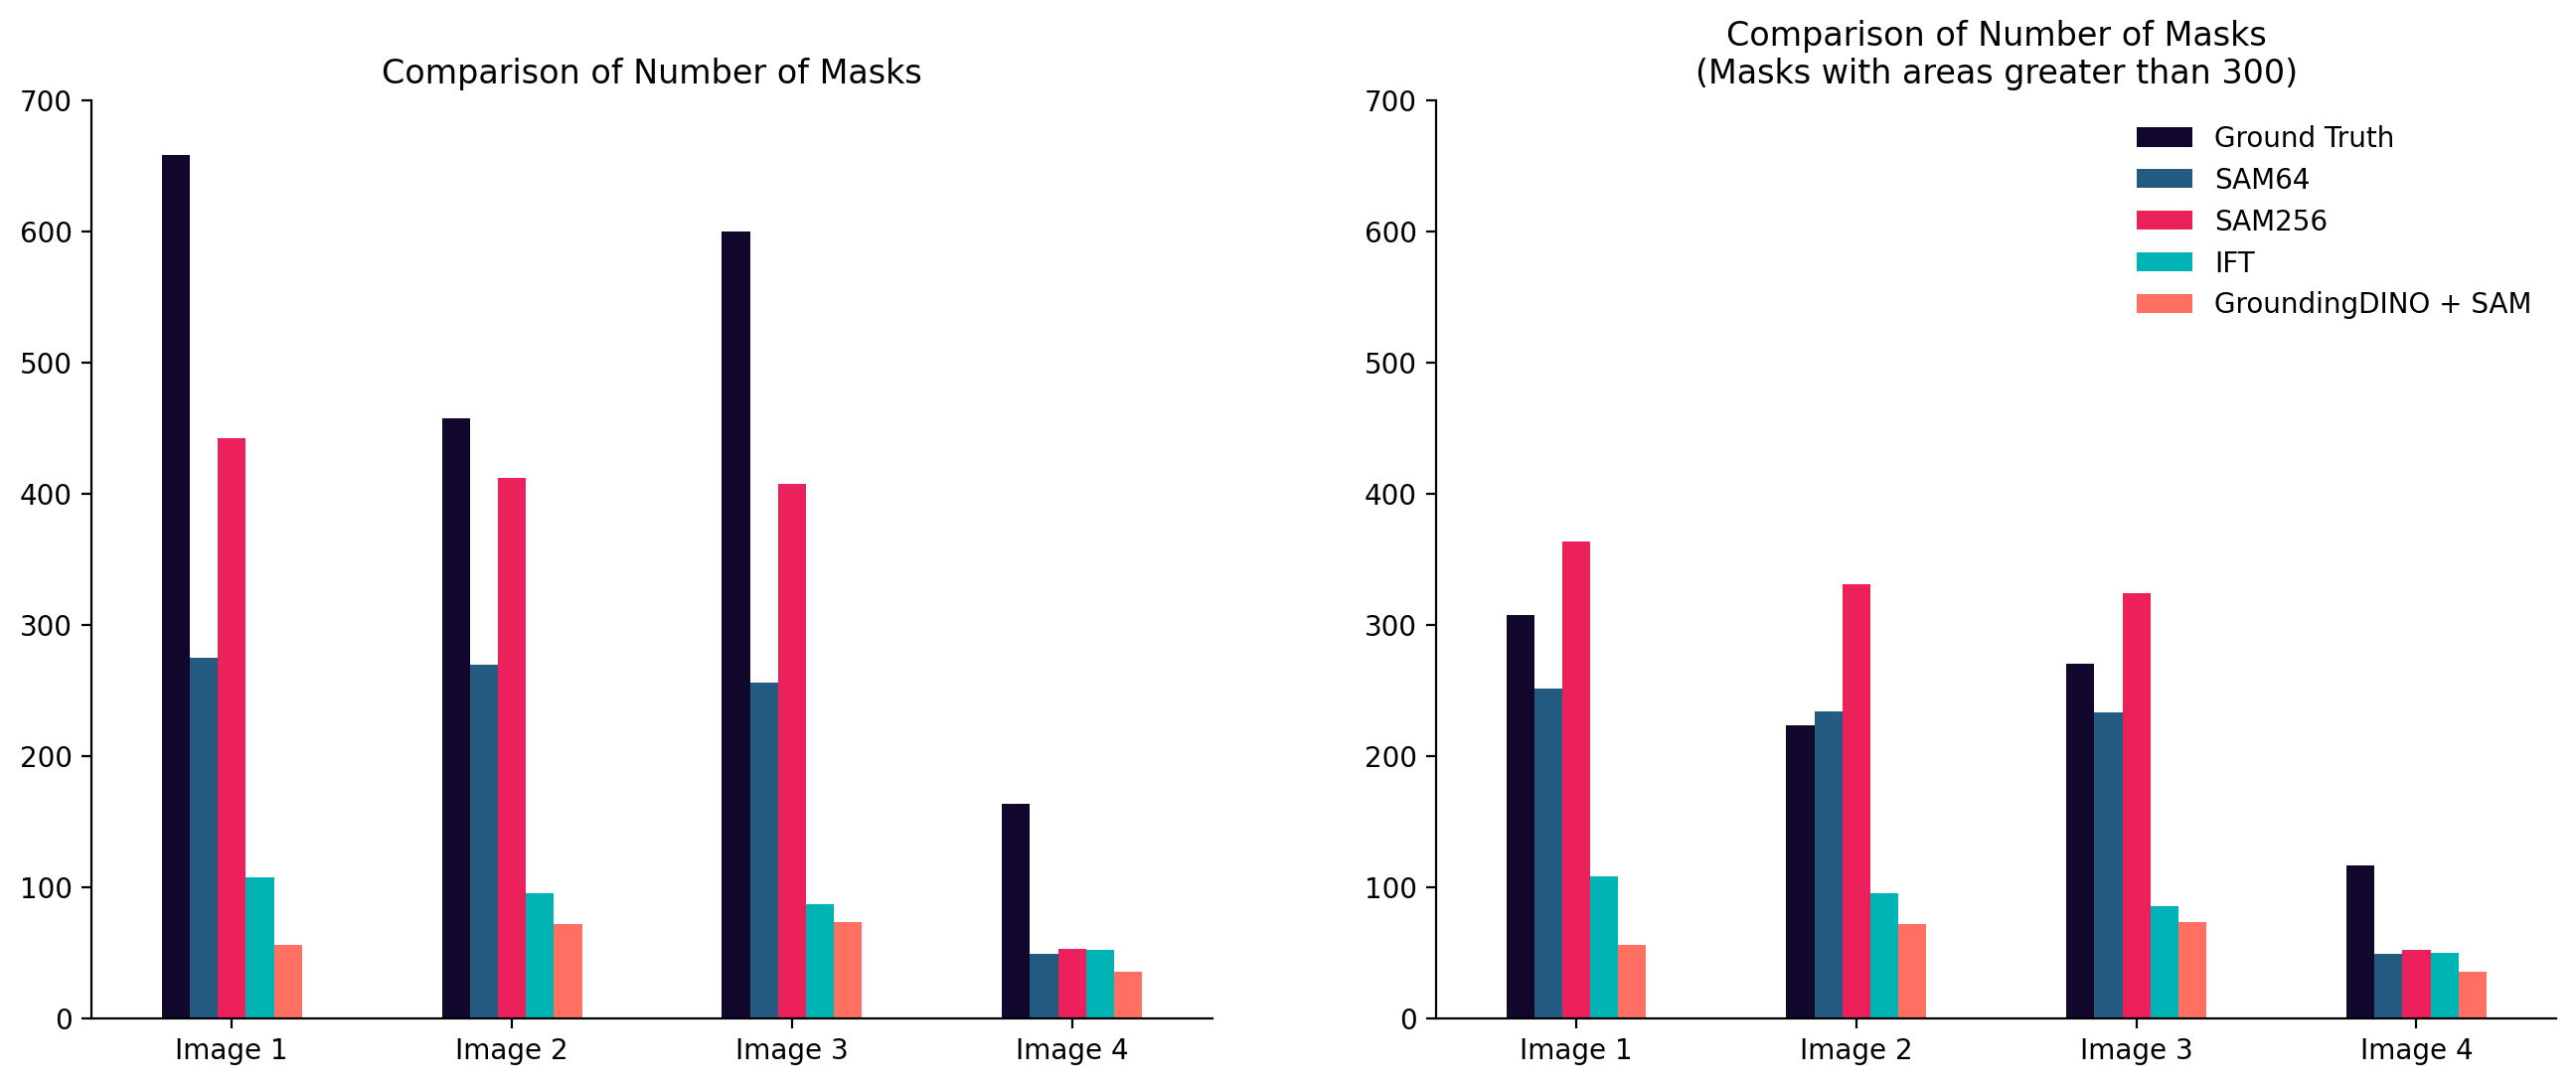

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
n_masks_df.plot.bar(ax=ax1, rot=0, ylim=(0, 700), color=my_color_palette1, legend=None)
ax1.spines[["right", "top"]].set_visible(False)
ax1.set_title("Comparison of Number of Masks")

n_masks_300_df.plot.bar(ax=ax2, rot=0, ylim=(0, 700), color=my_color_palette1, legend=None)
ax2.spines[["right", "top"]].set_visible(False)
ax2.legend(loc="upper right", frameon=False)
ax2.set_title("Comparison of Number of Masks\n(Masks with areas greater than 300)")
fig.show()

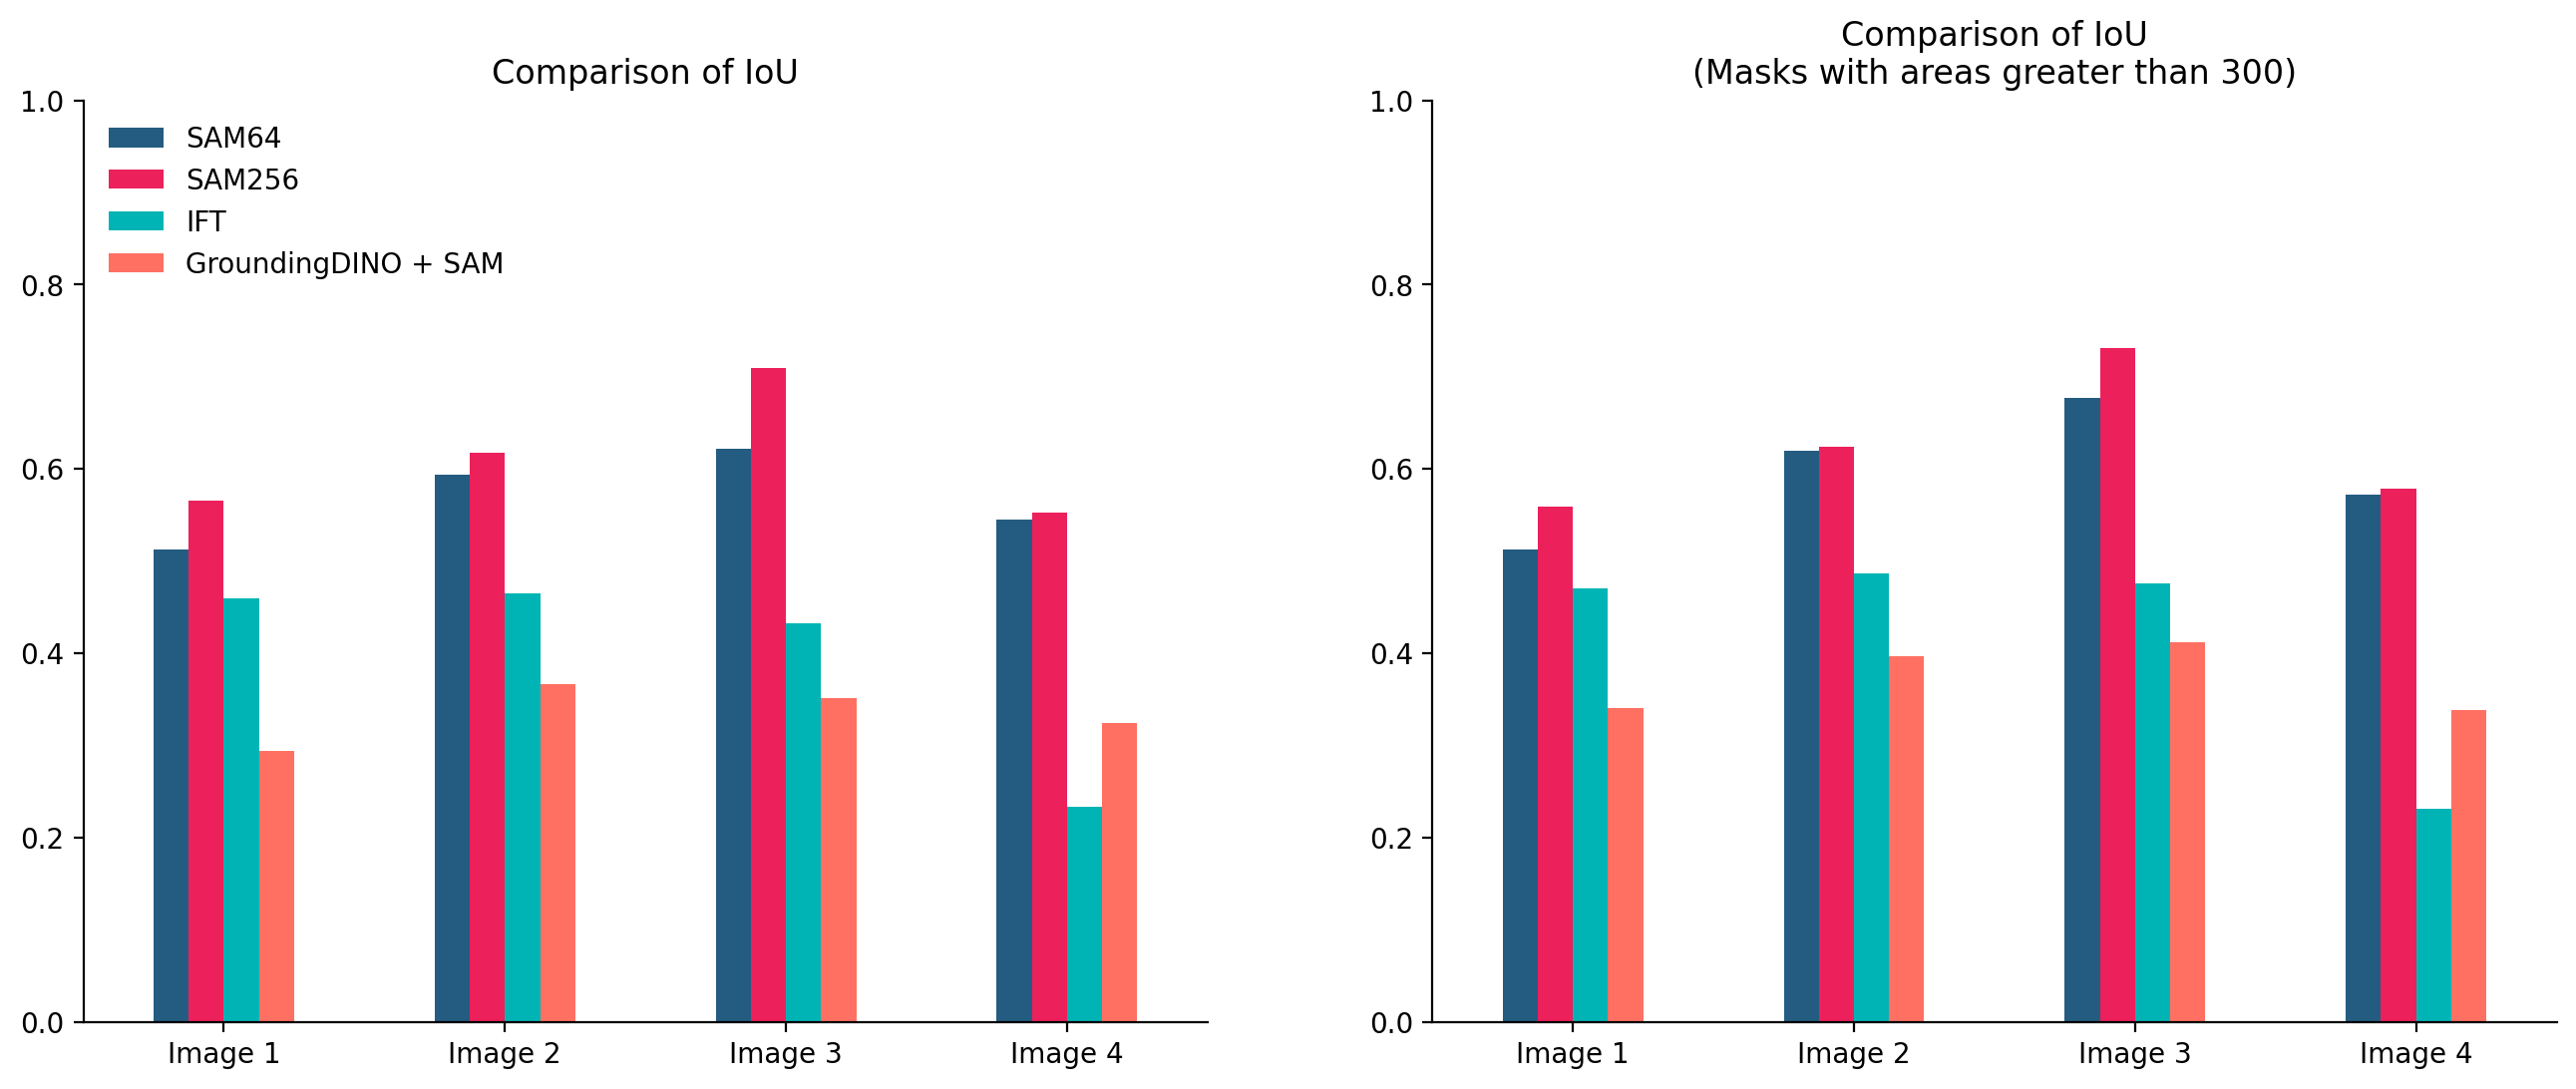

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
iou_df.plot.bar(ax=ax1, rot=0, ylim=(0, 1), color=my_color_palette, legend=None)
ax1.spines[["right", "top"]].set_visible(False)
ax1.legend(loc="upper left", frameon=False)
ax1.set_title("Comparison of IoU")

iou_300_df.plot.bar(ax=ax2, rot=0, ylim=(0, 1), color=my_color_palette, legend=None)
ax2.spines[["right", "top"]].set_visible(False)
ax2.set_title("Comparison of IoU\n(Masks with areas greater than 300)")
fig.show()